# Intro. To Data Science - Assignment 4 
## Excercise 4A 

In [28]:
# All neccessary libraries and packages needed to run the code contained within notebook
from sklearn.model_selection import cross_val_score
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import seaborn as sns
from scipy.stats import f_oneway
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import GridSearchCV
import random
from sklearn.ensemble import AdaBoostClassifier
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.model_selection import cross_val_score
from pylmnn import LargeMarginNearestNeighbor as LMNN
import GPyOpt
from sklearn.model_selection import GridSearchCV
from imblearn.combine import SMOTETomek
from matplotlib import figure
from pylmnn import LargeMarginNearestNeighbor as LMNN
import GPyOpt
from sklearn.model_selection import GridSearchCV
from imblearn.combine import SMOTETomek
from sklearn.neighbors import KNeighborsClassifier
from matplotlib import pyplot
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.ensemble import VotingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import svm
from collections import Counter

## Import and formatting of data

In [2]:

data = pd.read_csv(r"./data.csv",header = None)
labels = pd.read_csv(r"./labels.csv",header = None)
labels.columns = ["Label"]

feature_names = []
for i in range(0,data.shape[1]):
        feature_names.append("X" + str(i))
data.columns = feature_names



print(data.shape)
print(labels.shape)

(359, 186)
(179, 1)


#  Investigation into data features and labels

In [3]:
# split between labels in the data 
proportion_1 = labels["Label"].value_counts()[1]/(labels["Label"].value_counts()[1] + labels["Label"].value_counts()[2])
proportion_2 = labels["Label"].value_counts()[2]/(labels["Label"].value_counts()[1] + labels["Label"].value_counts()[2])
print("Proportion of samples labelled 1: " + str(proportion_1))
print("Proportion of samples labelled 2: " + str(proportion_2))



Proportion of samples labelled 1: 0.8715083798882681
Proportion of samples labelled 2: 0.12849162011173185


## Principal Component Analysis
Below we perform principal component analysis on the data set in attempt to reduce the dimensionality of the problem. it can be seen in the graphs below that there is a sharp decrease in the amount of variance expalined by the principal components with the amount for components being almost negligable beyond 25 Principal components. The cumulative graph of the variance explained outlines that upwards of 99.6% can be explained by 25 PC's or more. 

Proportion explained by 25 PC's: 0.996788


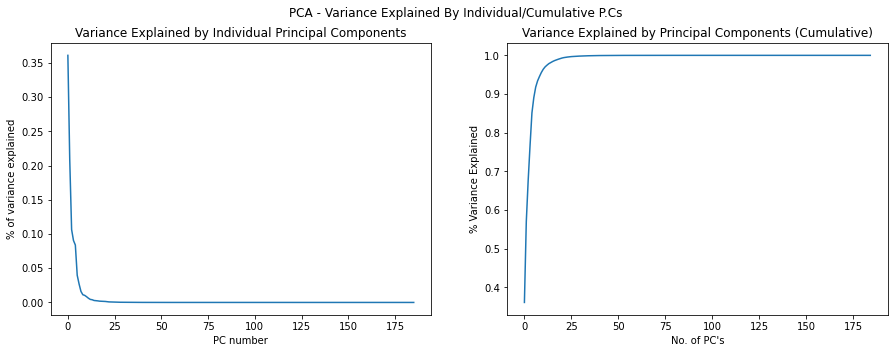

<Figure size 480x320 with 0 Axes>

In [4]:
# Principal Component analysis   -- should PCA only be done on training set??
#train_data = data.iloc[0:179,:]
standardized_features = pd.DataFrame(data - np.mean(data,axis = 0)) # pd.DataFrame(StandardScaler().fit_transform(data),columns = data.columns) #standardizing the data
covariance_matrix = standardized_features.cov() # taking covariance of columns of standardized data 

 # singular value decomposition of Covaraince matrix
eigen_values , eigen_vectors = np.linalg.eigh(covariance_matrix) #calculate eigenvalues/vectors of covariance matrix
sorted_index = np.argsort(eigen_values)[::-1] # index for sorting eigen values in descending orded 
sorted_eigenvalue = eigen_values[sorted_index] # sort eigen values in descending orded 
sorted_eigenvectors = eigen_vectors[:,sorted_index] # sort eigenvectors 
d = np.diag(sorted_eigenvalue) # create diagonal matrix of eigenvalues 

# function projects data on to specified number of components 
def Project_pca(num_components,last = False):
    if last == False:       
        component_vectors = sorted_eigenvectors[:,0:num_components]
        projected_data = pd.DataFrame(np.dot(component_vectors.T,standardized_features.T).T) # changed to standardized_features instead of data
        projected_data.columns = standardized_features.columns[0:num_components]
    else:
        component_vectors = sorted_eigenvectors[:,len(sorted_eigenvectors) - num_components:len(sorted_eigenvectors)]
        projected_data = pd.DataFrame(np.dot(component_vectors.T,standardized_features.T).T)
        projected_data.columns = standardized_features.columns[len(standardized_features.columns) - num_components:len(standardized_features.columns)]
        
    return projected_data

data_first_5PC = Project_pca(5)
data_last_5PC = Project_pca(5,last = True)

ind_prop_explained = sorted_eigenvalue/sum(sorted_eigenvalue) # proportion of variance explained by each principal component individually


#print(data)
#eigenvectors_T.head(5).dot(data.T) #projects data on to first 5 principal components

# cumulative proportion of variance explained by principal components.
# approx 75 principal components seems 
prop_explained = []
for i in range(1,len(sorted_eigenvectors)):
    prop_explained.append(sum(ind_prop_explained[0:i]))
print("Proportion explained by 25 PC's: %f" % prop_explained[25])


figure,axis = plt.subplots(1,2,figsize=(15, 5))

figure.suptitle('PCA - Variance Explained By Individual/Cumulative P.Cs')

plt.figure(figsize=(6, 4), dpi=80)
axis[0].set_title("Variance Explained by Individual Principal Components")
axis[0].plot(ind_prop_explained)#,title = "Variance Explained by Individual Principal Components")
axis[0].set(xlabel = 'PC number') 
axis[0].set(ylabel = '% of variance explained')

axis[1].set_title("Variance Explained by Principal Components (Cumulative)")
axis[1].plot(prop_explained)
axis[1].set(xlabel = "No. of PC's")
axis[1].set(ylabel = "% Variance Explained")
plt.show()


plt.show()

It can be seen in the scales of two boxplots below, which contains boxplots of the first 5 principal components and last 5 principal components, that the variance of the first 5 PC's is far greater than the last 5 which is as expected.

[Text(0.5, 0, 'Principal Component Number'),
 Text(0, 0.5, 'Variance'),
 Text(0.5, 1.0, 'last 5 Principal Components')]

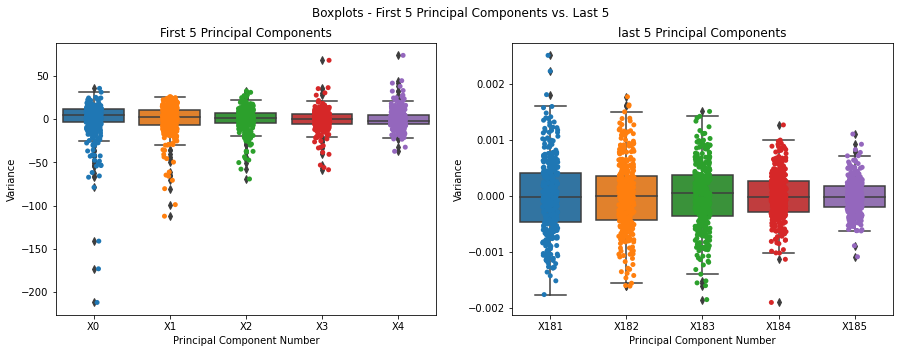

In [5]:
# boxplots of data projected on to first 5 principal components

figure,(ax1,ax2) = plt.subplots(1,2,figsize=(15,5))

figure.suptitle('Boxplots - First 5 Principal Components vs. Last 5')


sns.boxplot(data=data_first_5PC,ax=ax1)
sns.stripplot(data=data_first_5PC,ax=ax1).set(xlabel = 'Principal Component Number',ylabel = 'Variance',title = 'First 5 Principal Components')

sns.boxplot(data=data_last_5PC,ax=ax2)
sns.stripplot(data=data_last_5PC,ax=ax2).set(xlabel = 'Principal Component Number',ylabel = 'Variance',title = 'last 5 Principal Components')



## Comparing Distributions of Training And Testing sets
In this section we compare the distribution the features in the training and testing sets in search for an discrepencies firstly by looking at the distributions of the raw data and then the data after being project on to the first 3 principal components. It can be seen that the distributions for training and testing both with and without principal component analysis remain similar throughout.

Text(0.5, 1.0, 'X105')

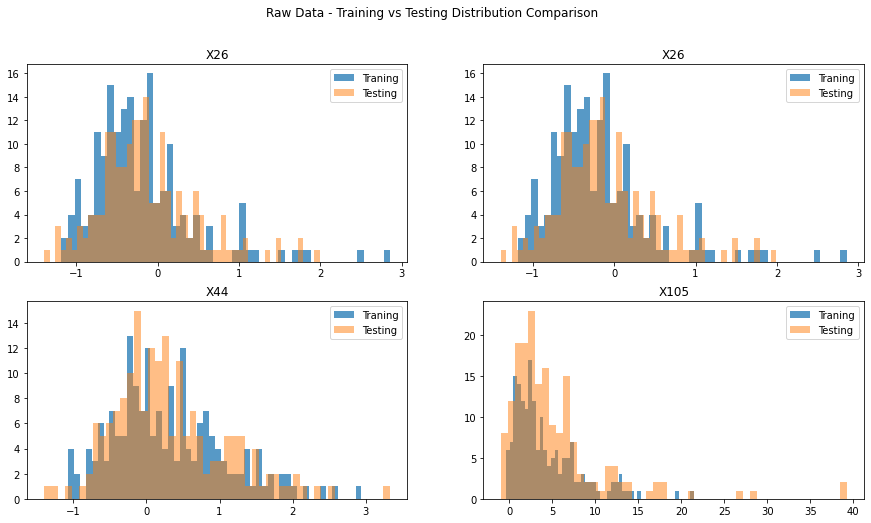

In [6]:
# compare the distribution between training and testing data 
# selects random columns and plots distributions of training and testing data  
# should this comparison be before or after preprocessing?

rand_column_index = np.sort(np.random.randint(0,data.shape[1],5))
rand_column_names = ["X" + str(i) for i in rand_column_index]

full_train_data = data.iloc[0:179,:]
test_data = data.iloc[179:data.shape[0],:]

hist_handles = ["Training","Testing"]
figure,axis = plt.subplots(2,2,figsize=(15, 8))

figure.suptitle('Raw Data - Training vs Testing Distribution Comparison') 

axis[0,0].hist(full_train_data[rand_column_names[0]],bins = 50,alpha = 0.75,label = "Traning")
axis[0,0].hist(test_data[rand_column_names[0]],bins = 50,alpha = 0.5,label = "Testing")
axis[0,0].legend()
axis[0,0].set_title(rand_column_names[0])

axis[0,1].hist(full_train_data[rand_column_names[1]],bins = 50,alpha = 0.75,label = "Traning")
axis[0,1].hist(test_data[rand_column_names[1]],bins = 50,alpha = 0.5,label = "Testing")
axis[0,1].legend()
axis[0,1].set_title(rand_column_names[1])

axis[1,0].hist(full_train_data[rand_column_names[2]],bins = 50,alpha = 0.75,label = "Traning")
axis[1,0].hist(test_data[rand_column_names[2]],bins = 50,alpha = 0.5,label = "Testing")
axis[1,0].legend()
axis[1,0].set_title(rand_column_names[2])

axis[1,1].hist(full_train_data[rand_column_names[3]],bins = 50,alpha = 0.75,label = "Traning")
axis[1,1].hist(test_data[rand_column_names[3]],bins = 50,alpha = 0.5,label = "Testing")
axis[1,1].legend()
axis[1,1].set_title(rand_column_names[3])

Text(0.5, 1.0, 'X2')

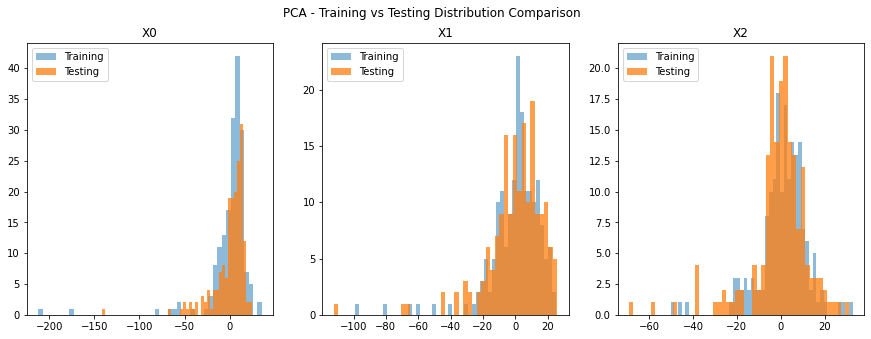

In [7]:
# comparison of distribution of train/test data when using 3 principal components'
#PC2
full_data_3PC = Project_pca(3)

test_data = full_data_3PC.iloc[179:data.shape[0],:]
train_data_3PC = full_data_3PC.iloc[0:179,:]


figure,axis = plt.subplots(1,3,figsize = (15,5))


figure.suptitle('PCA - Training vs Testing Distribution Comparison') 

axis[0].hist(train_data_3PC["X0"],bins = 50,alpha = 0.5,label = "Training")
axis[0].hist(test_data["X0"],bins = 50,alpha = 0.75,label = "Testing")
axis[0].legend()
axis[0].set_title("X0")

axis[1].hist(train_data_3PC["X1"],bins = 50,alpha = 0.5,label = "Training")
axis[1].hist(test_data["X1"],bins = 50,alpha = 0.75,label = "Testing")
axis[1].legend()
axis[1].set_title("X1")

axis[2].hist(train_data_3PC["X2"],bins = 50,alpha = 0.5,label = "Training")
axis[2].hist(test_data["X2"],bins = 50,alpha = 0.75,label = "Testing")
axis[2].legend()
axis[2].set_title("X2")

## ANOVA
Here we use ANOVA, specifically f_tests, to gauge the importance of each feature in hopes also to reduce the dimensionality. Outputed is is a list of features and there scores ordered from most important to least important aswell as a graph showing the scale of th importance for each feature.

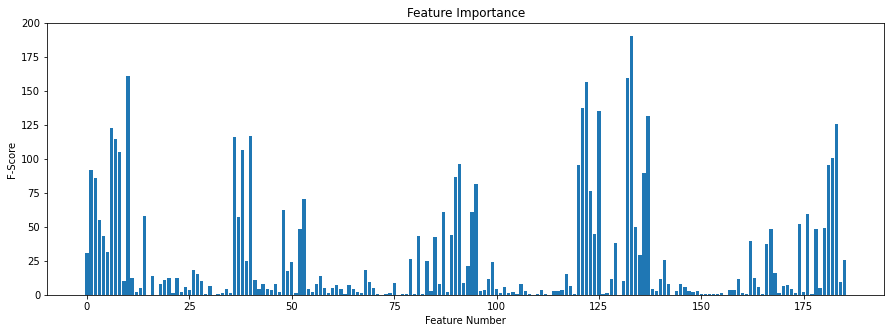

In [9]:
############### ANOVA #################

f_tests = SelectKBest(score_func=f_classif, k='all') # will compute ANOVA f value 

full_train_features = data.iloc[0:179,:]
test_data = data.iloc[179:data.shape[0],:]
train_labels = labels

f_tests.fit(full_train_features, labels.values.ravel())


feature_scores = pd.DataFrame(f_tests.scores_)
feature_scores.columns = ["Score"]
feature_scores_ordered = feature_scores.sort_values(by = "Score",ascending = False)


# function outputs top N features from training data 
def top_features(N_features):
    top_N_features = feature_scores_ordered.index[0:N_features]
    top_N_features = ["X" + str(top_N_features[i]) for i in range(0,len(top_N_features))]
    top_N_features = data[:,top_N_features]
    return top_N_features

#for i in range(feature_scores.shape[0]):
 #   print('Feature %d: %f' % (feature_scores_ordered.index[i])
    

# outputs scores for each feature and orders highest to lowest
#for i in range(feature_scores.shape[0]):
#	print('Feature %d: %f' % (feature_scores_ordered.index[i], feature_scores_ordered.iloc[i,0]))

# plots the scores for each feature
plt.figure(figsize=(15, 5))
plt.bar([i for i in range(feature_scores.shape[0])], feature_scores.iloc[:,0])
plt.xlabel('Feature Number')
plt.ylabel('F-Score')
plt.title('Feature Importance')
plt.show()

[Text(0.5, 0, 'Feature NUmber'),
 Text(0, 0.5, 'Value'),
 Text(0.5, 1.0, 'last 5 Features')]

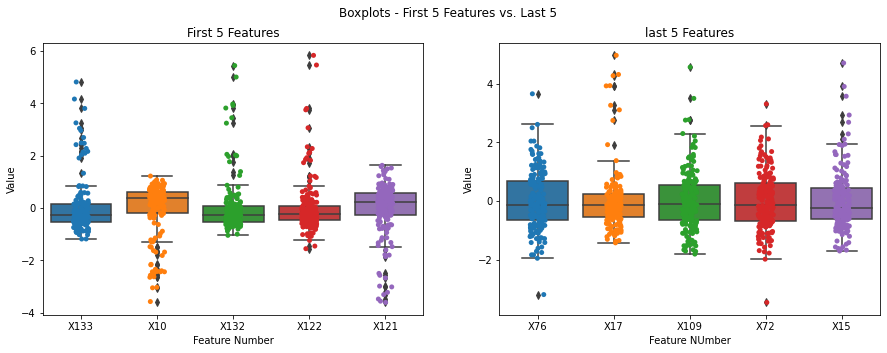

In [10]:
# boxplots of the top 5 features and the last 5 featuers found in ANOVA analysis 
standardized_train_data = pd.DataFrame(StandardScaler().fit_transform(full_train_data),columns = full_train_data.columns) #standardizing the data

top_5_features = feature_scores_ordered.index[0:5]
top_5_features = ["X" + str(top_5_features[i]) for i in range(0,len(top_5_features))]
top_5_features = standardized_train_data.loc[:,top_5_features]

last_5_features = feature_scores_ordered.index[len(feature_scores_ordered.index) - 5:len(feature_scores_ordered.index)]
last_5_features = ["X" + str(last_5_features[i]) for i in range(0,len(last_5_features))]
last_5_features = standardized_train_data.loc[:,last_5_features]


figure,(ax1,ax2) = plt.subplots(1,2,figsize=(15,5))
figure.suptitle('Boxplots - First 5 Features vs. Last 5')


sns.boxplot(data=top_5_features,ax=ax1)
sns.stripplot(data=top_5_features,ax=ax1).set(xlabel = 'Feature Number',ylabel = 'Value',title = 'First 5 Features')

sns.boxplot(data=last_5_features,ax=ax2)
sns.stripplot(data=last_5_features,ax=ax2).set(xlabel = 'Feature NUmber',ylabel = 'Value',title = 'last 5 Features')



## Labelled Data analysis
Next we look at the labelled data after preprocessing to potentially spot if there are any obvious distinguishing charecteristics for the classes as well as providing insight into the complexity of the problem.

(180, 186)
(179, 187)
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 179 samples in 0.000s...
[t-SNE] Computed neighbors for 179 samples in 0.063s...
[t-SNE] Computed conditional probabilities for sample 179 / 179
[t-SNE] Mean sigma: 10.652072
[t-SNE] KL divergence after 250 iterations with early exaggeration: 122.890617
[t-SNE] KL divergence after 1000 iterations: 2.068644


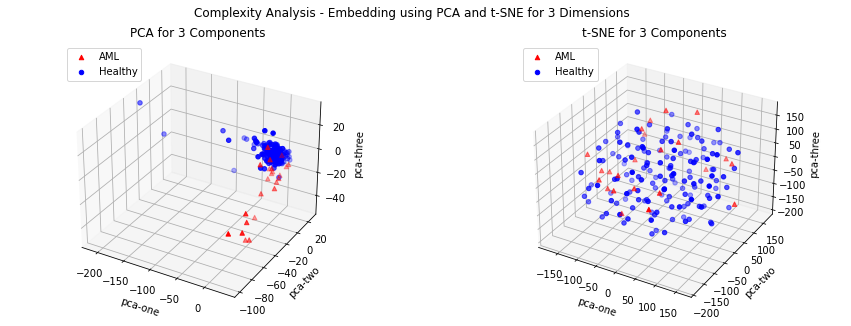

In [11]:
###################### Scatter plots PCA and t-SNE in 3 dimensions) ###################

# data with labels 
full_train_data = data.iloc[0:179,:]
full_train_data = pd.concat([full_train_data,labels],axis = 1)

# test data (labels need to be predicted)
test_data = data.iloc[179:data.shape[0],:]
print(test_data.shape)
print(full_train_data.shape)

# Cases known to have AML
AML_cases = full_train_data[full_train_data['Label'] == 2]

# Healthy Cases
healthy_cases = full_train_data[full_train_data['Label'] == 1]


#### data for just 3 Principal Components 
full_data_3PC = Project_pca(3)
full_train_data_3PC = full_data_3PC.iloc[0:179,:]
full_train_data_3PC = pd.concat([full_train_data_3PC,labels],axis = 1)
# Cases known to have AML
AML_cases_3PC = full_train_data_3PC[full_train_data_3PC['Label'] == 2]

# Healthy Cases
healthy_cases_3PC = full_train_data_3PC[full_train_data_3PC['Label'] == 1]

############## tsne
tsne = TSNE(n_components=3, verbose=1, random_state=123)
tsne_fit = pd.DataFrame(tsne.fit_transform(data.iloc[0:179,:]) )

tsne_fit = pd.concat([tsne_fit,labels],axis = 1)
AML_cases_tsne = tsne_fit[tsne_fit['Label'] == 2]
healthy_cases_tsne = tsne_fit[tsne_fit['Label'] == 1]
#####################


 
fig,(ax,ax2) = plt.subplots(1,2,figsize=(15,5))

# removes outside axis labels for containing box
ax.axis('off')
ax2.axis('off')

fig.suptitle('Complexity Analysis - Embedding using PCA and t-SNE for 3 Dimensions') 

# 3D scatter plot for 3 PC's 
ax = fig.add_subplot(1,2,1,projection='3d')
ax.scatter(
    xs = AML_cases_3PC.iloc[:,0],
    ys = AML_cases_3PC.iloc[:,1],
    zs = AML_cases_3PC.iloc[:,2],
    c = 'r',
    marker = '^',
    label = "AML")

ax.scatter(
    xs = healthy_cases_3PC.iloc[:,0],
    ys = healthy_cases_3PC.iloc[:,1],
    zs = healthy_cases_3PC.iloc[:,2],
    c = 'b',
    marker = 'o',
    label = "Healthy")
ax.set_xlabel('pca-one')
ax.set_ylabel('pca-two')
ax.set_zlabel('pca-three')
ax.set_title('PCA for 3 Components')
ax.legend(loc="upper left")



### tSNE scatter plots
ax2 = fig.add_subplot(1,2,2,projection='3d')
ax2.scatter(
    xs = AML_cases_tsne.iloc[:,0],
    ys = AML_cases_tsne.iloc[:,1],
    zs = AML_cases_tsne.iloc[:,2],
    c = 'r',
    marker = '^',
    label = "AML")

ax2.scatter(
    xs = healthy_cases_tsne.iloc[:,0],
    ys = healthy_cases_tsne.iloc[:,1],
    zs = healthy_cases_tsne.iloc[:,2],
    c = 'b',
    marker = 'o',
    label = "Healthy")
ax2.set_xlabel('pca-one')
ax2.set_ylabel('pca-two')
ax2.set_zlabel('pca-three')
ax2.set_title('t-SNE for 3 Components')
ax2.legend(loc="upper left")

plt.show()


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 179 samples in 0.001s...
[t-SNE] Computed neighbors for 179 samples in 0.010s...
[t-SNE] Computed conditional probabilities for sample 179 / 179
[t-SNE] Mean sigma: 10.652072
[t-SNE] KL divergence after 250 iterations with early exaggeration: 60.873562
[t-SNE] KL divergence after 1000 iterations: 0.585135


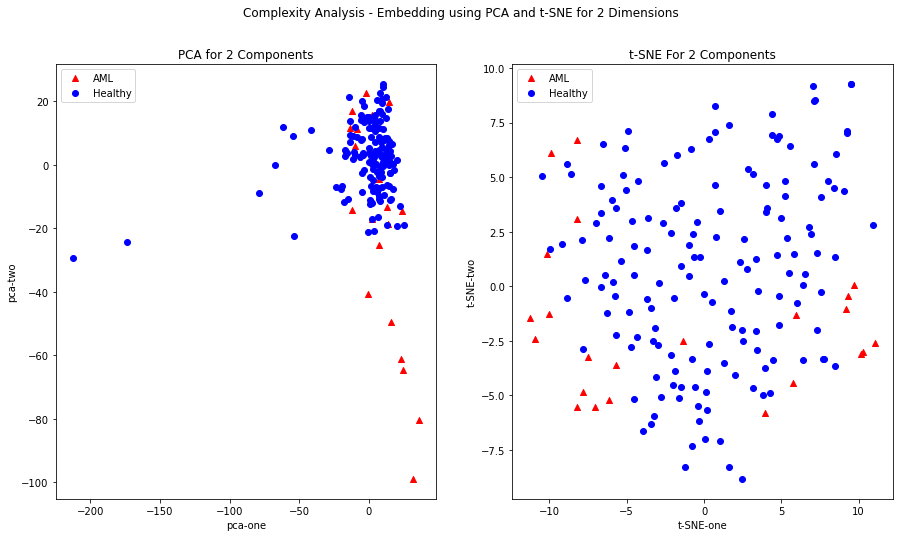

In [12]:
#### PCA vs tSNE in 2 dimensions

full_data_2PC = Project_pca(2)
full_train_data_2PC = full_data_2PC.iloc[0:179,:]
full_train_data_2PC = pd.concat([full_train_data_2PC,labels],axis = 1)
# Cases known to have AML
AML_cases_2PC = full_train_data_3PC[full_train_data_2PC['Label'] == 2]

# Healthy Cases
healthy_cases_2PC = full_train_data_2PC[full_train_data_2PC['Label'] == 1]

##### tsne #####
tsne = TSNE(n_components=2, verbose=1, random_state=123)
tsne_fit = pd.DataFrame(tsne.fit_transform(data.iloc[0:179,:]) )

tsne_fit = pd.concat([tsne_fit,labels],axis = 1)
AML_cases_tsne = tsne_fit[tsne_fit['Label'] == 2]
healthy_cases_tsne = tsne_fit[tsne_fit['Label'] == 1]



# 3D scatter plot for 3 PC's 
fig,(ax1,ax2) = plt.subplots(1,2,figsize = (15,8))

fig.suptitle('Complexity Analysis - Embedding using PCA and t-SNE for 2 Dimensions') 

### PCA plots
ax1.scatter(
    x = AML_cases_2PC.iloc[:,0],
    y = AML_cases_2PC.iloc[:,1],
    c = 'r',
    marker = '^',
    label = "AML")

ax1.scatter(
    x = healthy_cases_2PC.iloc[:,0],
    y = healthy_cases_2PC.iloc[:,1],
    c = 'b',
    marker = 'o',
    label = "Healthy")
ax1.set_xlabel('pca-one')
ax1.set_ylabel('pca-two')
ax1.legend(loc="upper left")
ax1.set_title("PCA for 2 Components")

### tsne plots
ax2.scatter(
    x = AML_cases_tsne.iloc[:,0],
    y = AML_cases_tsne.iloc[:,1],
    c = 'r',
    marker = '^',
    label = "AML")

ax2.scatter(
    x = healthy_cases_tsne.iloc[:,0],
    y = healthy_cases_tsne.iloc[:,1],
    c = 'b',
    marker = 'o',
    label = "Healthy")#
ax2.set_xlabel('t-SNE-one')
ax2.set_ylabel('t-SNE-two')
ax2.set_title("t-SNE For 2 Components")
ax2.legend(loc="upper left")

plt.show()


In [13]:
# Possible pre-processed data sets to use in modelling 

full_data_25PC = Project_pca(25) # from principal component analysis
full_data_25PC = full_data_25PC .iloc[0:179,:]

# z-score standardized data
standardized_train_data = pd.DataFrame(StandardScaler().fit_transform(full_train_data),columns = full_train_data.columns)

# top 50 features 
#top_50_features = top_features(50)
# function outputs top N features from training data 
def top_features(N_features):
    top_N_features = feature_scores_ordered.index[0:N_features]
    top_N_features = ["X" + str(top_N_features[i]) for i in range(0,len(top_N_features))]
    top_N_features = data.loc[:,top_N_features]
    return top_N_features

top_features(19)


,X133,X10,X132,X122,X121,X125,X137,X183,X6,X40,X36,X7,X38,X8,X182,X91,X120,X181,X1
0,0.068480,0.58298,0.21570,0.030458,0.25078,0.52208,0.085537,0.061040,0.55527,0.61052,0.52289,0.073636,-1.02440,-1.293700,1.24830,0.059064,0.46953,0.107960,0.20750
1,0.128160,0.62379,0.23212,1.584700,0.18374,0.18132,0.105690,0.413140,0.57419,0.53459,0.45019,0.108670,-0.42802,-0.546090,1.29030,0.116820,0.26712,0.136890,0.19461
2,0.066061,0.59810,0.21516,0.311310,0.23083,0.43987,0.083719,0.597300,0.56315,0.63792,0.54974,0.087308,-1.11170,-1.236900,1.41990,0.062142,0.43111,0.111260,0.21277
3,0.055745,0.58387,0.19788,0.381210,0.22978,0.43624,0.066108,2.930500,0.55123,0.63262,0.51459,0.079356,-0.61174,-0.748220,1.93490,0.065238,0.39884,0.081009,0.21100
4,0.048515,0.61140,0.18656,0.453330,0.22874,0.41287,0.063812,1.020400,0.58742,0.64409,0.57354,0.073633,-1.25010,-1.312000,1.54850,0.067447,0.40437,0.120930,0.17246
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354,0.065211,0.56871,0.23093,0.050124,0.21744,0.39502,0.091782,-0.362530,0.55693,0.65025,0.60231,0.057224,-1.75770,-1.838100,1.05010,0.051231,0.48842,0.106230,0.17289
355,0.052984,0.62821,0.18130,0.094238,0.24292,0.49367,0.061315,-0.104440,0.60342,0.65465,0.57713,0.078787,-1.39610,-1.472900,1.13660,0.076153,0.45614,0.120800,0.18870
356,0.052019,0.59277,0.18342,0.153750,0.21696,0.41639,0.065628,-0.584520,0.57663,0.68716,0.62382,0.065752,-1.62070,-1.336300,0.95638,0.070933,0.42865,0.123390,0.19058
357,0.055144,0.53188,0.17578,0.754580,0.21784,0.39160,0.056464,0.837110,0.52168,0.24330,0.36365,0.089261,0.62145,-0.093587,1.34980,0.087799,0.32275,0.090423,0.21383


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 179 samples in 0.000s...
[t-SNE] Computed neighbors for 179 samples in 0.017s...
[t-SNE] Computed conditional probabilities for sample 179 / 179
[t-SNE] Mean sigma: 10.652388
[t-SNE] KL divergence after 250 iterations with early exaggeration: 60.369877
[t-SNE] KL divergence after 850 iterations: 0.602720
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 179 samples in 0.000s...
[t-SNE] Computed neighbors for 179 samples in 0.005s...
[t-SNE] Computed conditional probabilities for sample 179 / 179
[t-SNE] Mean sigma: 10.642476
[t-SNE] KL divergence after 250 iterations with early exaggeration: 60.569733
[t-SNE] KL divergence after 1000 iterations: 0.551318
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 179 samples in 0.000s...
[t-SNE] Computed neighbors for 179 samples in 0.005s...
[t-SNE] Computed conditional probabilities for sample 179 / 179
[t-SNE] Mean sigma: 4.976924
[t-SNE] KL divergence after 250 iterati

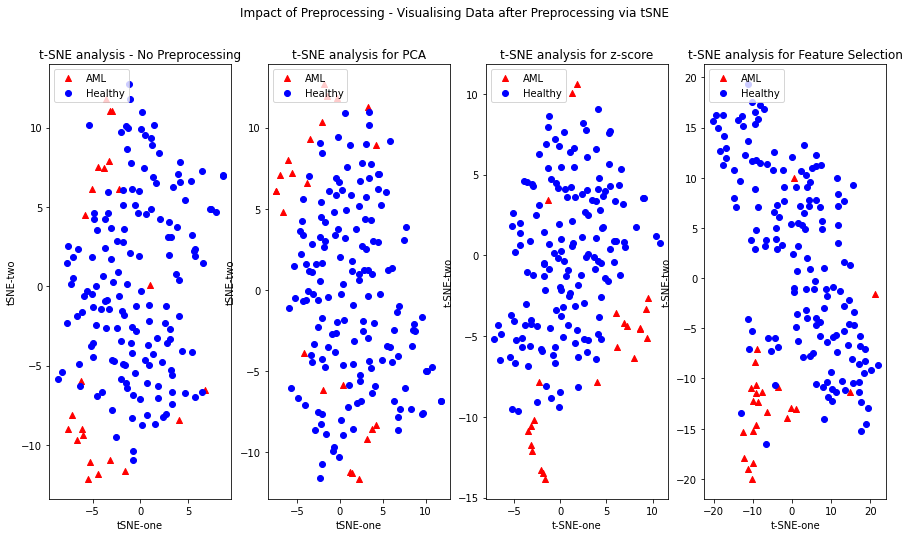

In [15]:
### using tSNE to visualize the impact of preprocessing on the data


full_data_25PC = Project_pca(25) # from principal component analysis
full_data_25PC = full_data_25PC.iloc[0:179,:]

# z-score standardized data
standardized_train_data = pd.DataFrame(StandardScaler().fit_transform(full_train_data),columns = full_train_data.columns)


# top 50 features 
top_50_features = top_features(50)


################# t-SNE on pre-processed data sets

# No preprocessing
tsne = TSNE(n_components=2, verbose=1, random_state=123)
tsne_fit = pd.DataFrame(tsne.fit_transform(full_train_data) )
tsne_fit = pd.concat([tsne_fit,labels],axis = 1)
AML_cases_tsne = tsne_fit[tsne_fit['Label'] == 2]
healthy_cases_tsne = tsne_fit[tsne_fit['Label'] == 1]


### PCA
tsne_PC = TSNE(n_components=2, verbose=1, random_state=123)
tsne_fit_PC = pd.DataFrame(tsne_PC.fit_transform(full_data_25PC) )
tsne_fit_PC = pd.concat([tsne_fit_PC,labels],axis = 1)
AML_cases_tsne_PC = tsne_fit_PC[tsne_fit_PC['Label'] == 2]
healthy_cases_tsne_PC = tsne_fit_PC[tsne_fit_PC['Label'] == 1]


### z score standardized
tsne_Z = TSNE(n_components=2, verbose=1, random_state=123)
tsne_fit_Z = pd.DataFrame(tsne_Z.fit_transform(standardized_train_data) )
tsne_fit_Z = pd.concat([tsne_fit_Z,labels],axis = 1)
AML_cases_tsne_Z = tsne_fit_Z[tsne_fit_Z['Label'] == 2]
healthy_cases_tsne_Z = tsne_fit_Z[tsne_fit_Z['Label'] == 1]


### Feature selection
tsne_FS = TSNE(n_components=2, verbose=1, random_state=123)
tsne_fit_FS = pd.DataFrame(tsne_FS.fit_transform(top_50_features) )
tsne_fit_FS = pd.concat([tsne_fit_FS,labels],axis = 1)
AML_cases_tsne_FS = tsne_fit_FS[tsne_fit_FS['Label'] == 2]
healthy_cases_tsne_FS = tsne_fit_FS[tsne_fit_FS['Label'] == 1]


fig,(ax0,ax1,ax2,ax3) = plt.subplots(1,4,figsize = (15,8))

fig.suptitle('Impact of Preprocessing - Visualising Data after Preprocessing via tSNE') 


ax0.scatter(
    x = AML_cases_tsne.iloc[:,0],
    y = AML_cases_tsne.iloc[:,1],
    c = 'r',
    marker = '^',
    label = "AML")

ax0.scatter(
    x = healthy_cases_tsne.iloc[:,0],
    y = healthy_cases_tsne.iloc[:,1],
    c = 'b',
    marker = 'o',
    label = "Healthy")
ax0.set_xlabel('tSNE-one')
ax0.set_ylabel('tSNE-two')
ax0.legend(loc="upper left")
ax0.set_title("t-SNE analysis - No Preprocessing")




### PCA plots
ax1.scatter(
    x = AML_cases_tsne_PC.iloc[:,0],
    y = AML_cases_tsne_PC.iloc[:,1],
    c = 'r',
    marker = '^',
    label = "AML")

ax1.scatter(
    x = healthy_cases_tsne_PC.iloc[:,0],
    y = healthy_cases_tsne_PC.iloc[:,1],
    c = 'b',
    marker = 'o',
    label = "Healthy")
ax1.set_xlabel('tSNE-one')
ax1.set_ylabel('tSNE-two')
ax1.legend(loc="upper left")
ax1.set_title("t-SNE analysis for PCA")

### Z - score plots
ax2.scatter(
    x = AML_cases_tsne_Z.iloc[:,0],
    y = AML_cases_tsne_Z.iloc[:,1],
    c = 'r',
    marker = '^',
    label = "AML")

ax2.scatter(
    x = healthy_cases_tsne_Z.iloc[:,0],
    y = healthy_cases_tsne_Z.iloc[:,1],
    c = 'b',
    marker = 'o',
    label = "Healthy")#
ax2.set_xlabel('t-SNE-one')
ax2.set_ylabel('t-SNE-two')
ax2.set_title("t-SNE analysis for z-score")
ax2.legend(loc="upper left")

### Feature Selection plots
ax3.scatter(
    x = AML_cases_tsne_FS.iloc[:,0],
    y = AML_cases_tsne_FS.iloc[:,1],
    c = 'r',
    marker = '^',
    label = "AML")

ax3.scatter(
    x = healthy_cases_tsne_FS.iloc[:,0],
    y = healthy_cases_tsne_FS.iloc[:,1],
    c = 'b',
    marker = 'o',
    label = "Healthy")#
ax3.set_xlabel('t-SNE-one')
ax3.set_ylabel('t-SNE-two')
ax3.set_title("t-SNE analysis for Feature Selection")
ax3.legend(loc="upper left")

plt.show()

# Model Training 

In [16]:
def selected_features(num_components):
    full_train_features = data.iloc[0:179,:]
    
    highf = SelectKBest(score_func=f_classif, k=num_components)
    
    X_kbest = highf.fit_transform(full_train_features, labels.values.ravel())
    return X_kbest

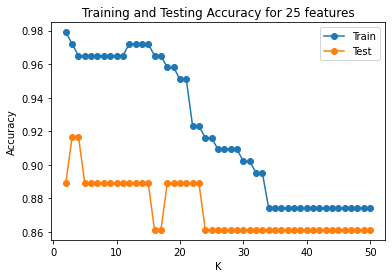

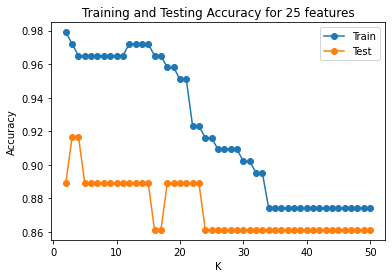

In [17]:
#GENERATING A GRAPH TO OBSERVE OVERFITTING

k_accuracy_scores = []

features = selected_features(25)


# with the training data that does have labels split in to training and validation
X_train,X_test,y_train,y_test = train_test_split(features,
                                                                     labels,
                                                                     test_size = 0.2,
                                                                     stratify = labels, # ensures there are samples with both labels in train and test data
                                                                    random_state = 42)
    
k=[i for i in range(2, 51)]

train_scores=[]
test_scores=[]

for j in k:
    clf = KNeighborsClassifier(n_neighbors=j,n_jobs=-1)
    clf.fit(X_train, y_train.values.ravel())
    # evaluate on the train dataset
    train_pred = clf.predict(X_train)
    train_acc = accuracy_score(y_train, train_pred)
    train_scores.append(train_acc)
    # evaluate on the test dataset
    test_pred = clf.predict(X_test)
    test_acc = accuracy_score(y_test, test_pred)
    test_scores.append(test_acc)
    
pyplot.plot(k, train_scores, '-o', label='Train')
pyplot.plot(k, test_scores, '-o', label='Test')
pyplot.ylabel('Accuracy')
pyplot.xlabel('K')
pyplot.legend()
pyplot.title('Training and Testing Accuracy for 25 features')
pyplot.show()
#GENERATING A GRAPH TO OBSERVE OVERFITTING
k_accuracy_scores = []

features = selected_features(25)


# with the training data that does have labels split in to training and validation
X_train,X_test,y_train,y_test = train_test_split(features,
                                                                     labels,
                                                                     test_size = 0.2,
                                                                     stratify = labels, # ensures there are samples with both labels in train and test data
                                                                    random_state = 42)
    
k=[i for i in range(2, 51)]

train_scores=[]
test_scores=[]

for j in k:
    clf = KNeighborsClassifier(n_neighbors=j,n_jobs=-1)
    clf.fit(X_train, y_train.values.ravel())
    # evaluate on the train dataset
    train_pred = clf.predict(X_train)
    train_acc = accuracy_score(y_train, train_pred)
    train_scores.append(train_acc)
    # evaluate on the test dataset
    test_pred = clf.predict(X_test)
    test_acc = accuracy_score(y_test, test_pred)
    test_scores.append(test_acc)
    
pyplot.plot(k, train_scores, '-o', label='Train')
pyplot.plot(k, test_scores, '-o', label='Test')
pyplot.ylabel('Accuracy')
pyplot.xlabel('K')
pyplot.legend()
pyplot.title('Training and Testing Accuracy for 25 features')
pyplot.show()


3 28 3 3


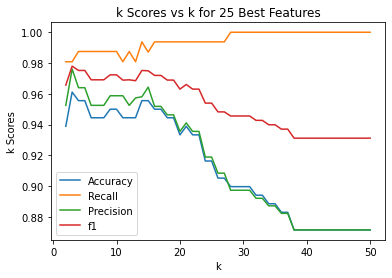

In [19]:
#KNN NO SMOTETOTEK
features = selected_features(25)

cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
k_accuracy_scores =[]
k_recall_scores =[]
k_precision_scores =[]
k_f1_scores =[]
k=[i for i in range(2, 51)]

for j in k:
    knn = KNeighborsClassifier(n_neighbors=j,n_jobs=-1)
    accuracy_scores = cross_val_score(knn, features,labels.values.ravel(),cv=cv,scoring='accuracy')
    recall_scores = cross_val_score(knn, features,labels.values.ravel(),cv=cv,scoring='recall')
    precision_scores = cross_val_score(knn, features,labels.values.ravel(),cv=cv,scoring='precision')
    f1_scores = cross_val_score(knn, features,labels.values.ravel(),cv=cv,scoring='f1')
    
    k_accuracy_scores.append(accuracy_scores.mean())
    k_recall_scores.append(recall_scores.mean())
    k_precision_scores.append(precision_scores.mean())
    k_f1_scores.append(f1_scores.mean())
    
    
acc_optimal_k = k[k_accuracy_scores.index(max(k_accuracy_scores))]
rec_optimal_k = k[k_recall_scores.index(max(k_recall_scores))]
pre_optimal_k = k[k_precision_scores.index(max(k_precision_scores))]
f1_optimal_k = k[k_f1_scores.index(max(k_f1_scores))]

print(acc_optimal_k, rec_optimal_k, pre_optimal_k, f1_optimal_k)
plt.plot(k,k_accuracy_scores,label = 'Accuracy')
plt.plot(k,k_recall_scores, label = 'Recall')
plt.plot(k,k_precision_scores, label = 'Precision')
plt.plot(k,k_f1_scores, label = 'f1')
plt.legend()
plt.title('k Scores vs k for 25 Best Features')
plt.xlabel('k')
plt.ylabel('k Scores')
plt.show()

4 2 3 2


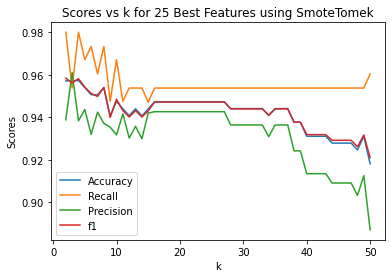

In [20]:
#KNN smotetomek
smotetomek = SMOTETomek(random_state=42)
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

selected = selected_features(25)

X_train_smotetomek, y_train_smotetomek = smotetomek.fit_resample(selected,labels)

k=[i for i in range(2, 51)]
k_accuracy_scores =[]
k_recall_scores =[]
k_precision_scores =[]
k_f1_scores =[]

for j in k:
    knn = KNeighborsClassifier(n_neighbors=j,n_jobs=-1)
    
    accuracy_scores = cross_val_score(knn, X_train_smotetomek,y_train_smotetomek.values.ravel(),cv=cv,scoring='accuracy')
    recall_scores = cross_val_score(knn, X_train_smotetomek,y_train_smotetomek.values.ravel(),cv=cv,scoring='recall')
    precision_scores = cross_val_score(knn, X_train_smotetomek,y_train_smotetomek.values.ravel(),cv=cv,scoring='precision')
    f1_scores = cross_val_score(knn, X_train_smotetomek,y_train_smotetomek.values.ravel(),cv=cv,scoring='f1')
    
    
    k_accuracy_scores.append(accuracy_scores.mean())
    k_recall_scores.append(recall_scores.mean())
    k_precision_scores.append(precision_scores.mean())
    k_f1_scores.append(f1_scores.mean())
      
acc_optimal_k = k[k_accuracy_scores.index(max(k_accuracy_scores))]
rec_optimal_k = k[k_recall_scores.index(max(k_recall_scores))]
pre_optimal_k = k[k_precision_scores.index(max(k_precision_scores))]
f1_optimal_k = k[k_f1_scores.index(max(k_f1_scores))]

print(acc_optimal_k, rec_optimal_k, pre_optimal_k, f1_optimal_k)
plt.plot(k,k_accuracy_scores,label = 'Accuracy')
plt.plot(k,k_recall_scores, label = 'Recall')
plt.plot(k,k_precision_scores, label = 'Precision')
plt.plot(k,k_f1_scores, label = 'f1')
plt.legend()
plt.title('Scores vs k for 25 Best Features using SmoteTomek')
plt.xlabel('k')
plt.ylabel('Scores')
plt.show()


5 8 5 8


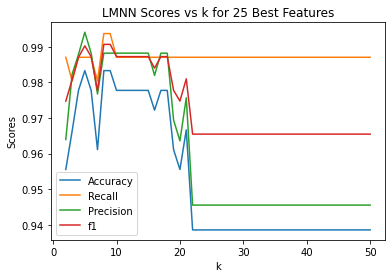

In [21]:
#lmnn NO SMOTETOTEK
features = selected_features(25)

cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
k_accuracy_scores =[]
k_recall_scores =[]
k_precision_scores =[]
k_f1_scores =[]
k=[i for i in range(2, 51)]

k_test, n_components, max_iter = 3, features.shape[1], 180



for j in k:
    
    lmnn = LMNN(n_neighbors=j, max_iter=max_iter, n_components=n_components)
    lmnn.fit(features, labels.values.ravel())
    
    knn = KNeighborsClassifier(n_neighbors=k_test,n_jobs=-1)
    knn.fit(lmnn.transform(features), labels.values.ravel())
    
    accuracy_scores = cross_val_score(knn, lmnn.transform(features),labels.values.ravel(),cv=cv,scoring='accuracy')
    recall_scores = cross_val_score(knn, lmnn.transform(features),labels.values.ravel(),cv=cv,scoring='recall')
    precision_scores = cross_val_score(knn, lmnn.transform(features),labels.values.ravel(),cv=cv,scoring='precision')
    f1_scores = cross_val_score(knn, lmnn.transform(features),labels.values.ravel(),cv=cv,scoring='f1')
    
    k_accuracy_scores.append(accuracy_scores.mean())
    k_recall_scores.append(recall_scores.mean())
    k_precision_scores.append(precision_scores.mean())
    k_f1_scores.append(f1_scores.mean())
    
    
acc_optimal_k = k[k_accuracy_scores.index(max(k_accuracy_scores))]
rec_optimal_k = k[k_recall_scores.index(max(k_recall_scores))]
pre_optimal_k = k[k_precision_scores.index(max(k_precision_scores))]
f1_optimal_k = k[k_f1_scores.index(max(k_f1_scores))]

print(acc_optimal_k, rec_optimal_k, pre_optimal_k, f1_optimal_k)
plt.plot(k,k_accuracy_scores,label = 'Accuracy')
plt.plot(k,k_recall_scores, label = 'Recall')
plt.plot(k,k_precision_scores, label = 'Precision')
plt.plot(k,k_f1_scores, label = 'f1')
plt.legend()
plt.title('LMNN Scores vs k for 25 Best Features')
plt.xlabel('k')
plt.ylabel('Scores')
plt.show()


3 3 2 3


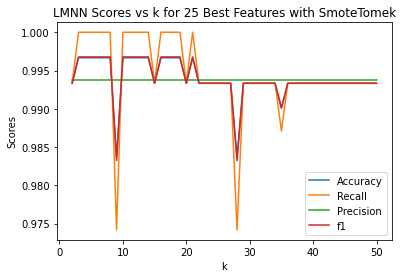

In [22]:
#lmnn SMOTETOTEK
features = selected_features(25)

cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
k_accuracy_scores =[]
k_recall_scores =[]
k_precision_scores =[]
k_f1_scores =[]
k=[i for i in range(2, 51)]

k_test, n_components, max_iter = 3, features.shape[1], 180

X_smotetomek, y_smotetomek = smotetomek.fit_resample(features,labels)


for j in k:
    
    lmnn = LMNN(n_neighbors=j, max_iter=max_iter, n_components=n_components)
    lmnn.fit(X_smotetomek, y_smotetomek)
    
    knn = KNeighborsClassifier(n_neighbors=k_test,n_jobs=-1)
    knn.fit(lmnn.transform(X_smotetomek), y_smotetomek)
    
    accuracy_scores = cross_val_score(knn, lmnn.transform(X_smotetomek),y_smotetomek,cv=cv,scoring='accuracy')
    recall_scores = cross_val_score(knn, lmnn.transform(X_smotetomek),y_smotetomek,cv=cv,scoring='recall')
    precision_scores = cross_val_score(knn, lmnn.transform(X_smotetomek),y_smotetomek,cv=cv,scoring='precision')
    f1_scores = cross_val_score(knn, lmnn.transform(X_smotetomek),y_smotetomek,cv=cv,scoring='f1')
    
    k_accuracy_scores.append(accuracy_scores.mean())
    k_recall_scores.append(recall_scores.mean())
    k_precision_scores.append(precision_scores.mean())
    k_f1_scores.append(f1_scores.mean())
    
    
acc_optimal_k = k[k_accuracy_scores.index(max(k_accuracy_scores))]
rec_optimal_k = k[k_recall_scores.index(max(k_recall_scores))]
pre_optimal_k = k[k_precision_scores.index(max(k_precision_scores))]
f1_optimal_k = k[k_f1_scores.index(max(k_f1_scores))]

print(acc_optimal_k, rec_optimal_k, pre_optimal_k, f1_optimal_k)
plt.plot(k,k_accuracy_scores,label = 'Accuracy')
plt.plot(k,k_recall_scores, label = 'Recall')
plt.plot(k,k_precision_scores, label = 'Precision')
plt.plot(k,k_f1_scores, label = 'f1')
plt.legend()
plt.title('LMNN Scores vs k for 25 Best Features with SmoteTomek')
plt.xlabel('k')
plt.ylabel('Scores')
plt.show()


In [22]:
#logistic
features = selected_features(186)

clf = LogisticRegression()
clf = clf.fit(features,labels.values.ravel())
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

param = [    
    {'penalty' : ['l1', 'l2', 'elasticnet', 'none'],
    'C' : np.logspace(-4, 4, 20),
    'solver' : ['lbfgs','newton-cg','liblinear','sag','saga'],
    'max_iter' : [100, 1000,2500, 5000]
    }
]

grid_search = GridSearchCV(estimator = clf,param_grid=param,cv=cv,n_jobs=-1)
grid_search.fit(features,labels.values.ravel())

print(grid_search.best_params_)

/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag

/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag

/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_log

/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag

/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_log

/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag

/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_log

/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_log

/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag

/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_log

/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_log

/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag

/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag

/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag

/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_log

/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_log

/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_log

/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_log

/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag

/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_log

/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_log

/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_log

/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_log

/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_log

/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_log

/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_log

/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_log

/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag

/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_log

/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag

/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_log

/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag

/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_log

/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_log

/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag

/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag

/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag

/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag

/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag

/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_log

/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag

/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag

/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag

/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag

/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag

/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag

/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag

/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag

/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag

/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag

/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag

/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag

/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag

/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regres

/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_log

/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag

/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_log

/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag

/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag

/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_log

/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag

/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag

/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag

/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_log

/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag

/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_log

/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regres

/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_log

/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_log

/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag

/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag

/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag

/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_log

/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regres

/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag

/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag

/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag

/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag

/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag

/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regres

/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_log

/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_log

/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag

/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag

/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_log

/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_log

/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag

/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag

/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag

/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_log

/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag

/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_log

/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.o

/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_log

/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag

/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_log

/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag

/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag

/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_log

/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The m

/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_log

/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag

/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag

/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_log

/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_log

/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag

/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_log

/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag

/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag

/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag

/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_log

/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag

/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regres

/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_log

/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag

/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_log

/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag

/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_log

/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_log

{'C': 206.913808111479, 'max_iter': 1000, 'penalty': 'l1', 'solver': 'liblinear'}


In [24]:
#logistic
clf = LogisticRegression(penalty = 'l1',C = 206.913808111479,solver = 'liblinear',max_iter = 1000)

LogReg = clf.fit(features,labels.values.ravel())
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

from sklearn.model_selection import cross_val_score

a = cross_val_score(LogReg,features,labels.values.ravel(),cv=cv,scoring='accuracy').mean()
b = cross_val_score(LogReg,features,labels.values.ravel(),cv=cv,scoring='recall').mean()
c = cross_val_score(LogReg,features,labels.values.ravel(),cv=cv,scoring='precision').mean()
d = cross_val_score(LogReg,features,labels.values.ravel(),cv=cv,scoring='f1').mean()

print("accuracy",a)
print("recall",b)
print("precision",c)
print("f1",d)

accuracy 0.961111111111111
recall 0.9933333333333334
precision 0.9700898692810458
f1 0.974938761428325


In [25]:
#svm
from sklearn import svm

features = selected_features(186)

param = {'C':[0.1,1,10,100,1000],'kernel':['rbf','poly','sigmoid','linear'],'degree':[1,2,3,4,5,6,7,8,9,10]}

clf = svm.SVC()
clf = clf.fit(features,labels.values.ravel())
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

grid_search = GridSearchCV(estimator = clf,param_grid=param,cv=cv,n_jobs=-1)
grid_search.fit(features,labels.values.ravel())
print(grid_search.best_params_)



{'C': 100, 'degree': 1, 'kernel': 'rbf'}


In [26]:
#svm
clf = svm.SVC(kernel = 'rbf',C = 100,degree = 1)

supvec = clf.fit(features,labels.values.ravel())
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

from sklearn.model_selection import cross_val_score

a = cross_val_score(supvec,features,labels.values.ravel(),cv=cv,scoring='accuracy').mean()
b = cross_val_score(supvec,features,labels.values.ravel(),cv=cv,scoring='recall').mean()
c = cross_val_score(supvec,features,labels.values.ravel(),cv=cv,scoring='precision').mean()
d = cross_val_score(supvec,features,labels.values.ravel(),cv=cv,scoring='f1').mean()

print("accuracy",a)
print("recall",b)
print("precision",c)
print("f1",d)

accuracy 0.961111111111111
recall 0.9745833333333334
precision 0.9816176470588236
f1 0.9775940017527892


In [11]:
#decision tree
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

features = selected_features(25)


clf = DecisionTreeClassifier(random_state = 42)
clf = clf.fit(features,labels.values.ravel())

param = {"criterion":["gini","entropy"],"splitter":["best","random"],
              "max_depth":range(1,10,1),"min_samples_leaf":range(1,20,1),
              "min_samples_split":range(2,20,1)}

grid_search = GridSearchCV(estimator = clf,param_grid=param,cv=cv,n_jobs=-1)
grid_search.fit(features,labels.values.ravel())

print(grid_search.best_params_)

{'criterion': 'gini', 'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 8, 'splitter': 'random'}


In [14]:
#decision tree
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

features = selected_features(25)


clf = DecisionTreeClassifier(random_state = 42)
clf = clf.fit(features,labels.values.ravel())

param = {"criterion":["gini"],"splitter":["random"],
              "max_depth":[3],"min_samples_leaf":[1],
              "min_samples_split":[8]}

grid_search = GridSearchCV(estimator = clf,param_grid=param,cv=cv,n_jobs=-1)
grid_search.fit(features,labels.values.ravel())

print(grid_search.best_params_)

{'criterion': 'gini', 'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 8, 'splitter': 'random'}


In [16]:
#decision tree
clf = DecisionTreeClassifier(criterion = "gini", max_depth = 3,min_samples_leaf = 1,min_samples_split =8, splitter = "random")
from sklearn.model_selection import cross_val_score

DecTre = clf.fit(features,labels.values.ravel())
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

a = cross_val_score(DecTre,features,labels.values.ravel(),cv=cv,scoring='accuracy').mean()
b = cross_val_score(DecTre,features,labels.values.ravel(),cv=cv,scoring='recall').mean()
c = cross_val_score(DecTre,features,labels.values.ravel(),cv=cv,scoring='precision').mean()
d = cross_val_score(DecTre,features,labels.values.ravel(),cv=cv,scoring='f1').mean()

print("accuracy",a)
print("recall",b)
print("precision",c)
print("f1",d)

accuracy 0.95
recall 0.9870833333333333
precision 0.9819852941176471
f1 0.9687316715542522


In [17]:
################################# Random Forest Classifier ############################## 


features = selected_features(25)

### search for best hyperparameters to use for the random forest classifier 

n_estimators = [5,20,50] # number of trees in the random forest
max_depth = [int(x) for x in np.linspace(20, 100, num = 5)] # maximum number of levels allowed in each decision tree
min_samples_split = [2, 6, 10] # minimum sample number to split a node
min_samples_leaf = [1,2,3, 4] # minimum sample number that can be stored in a leaf node

# creates dict. of parameters to be passed in to the grid search
parameters = {'n_estimators': n_estimators,
'max_depth': max_depth,
'min_samples_split': min_samples_split,
'min_samples_leaf': min_samples_leaf,
}

clf = RandomForestClassifier(random_state = 42) 
grid_search = GridSearchCV(estimator = clf,param_grid=parameters,cv=cv,n_jobs=-1)
grid_search.fit(features,labels.values.ravel())
print(grid_search.best_params_)

{'max_depth': 20, 'min_samples_leaf': 3, 'min_samples_split': 2, 'n_estimators': 5}


In [18]:
clf = RandomForestClassifier(random_state = 42, n_estimators= 5, max_depth = 20,min_samples_leaf = 3,min_samples_split =2)
from sklearn.model_selection import cross_val_score

RanFor = clf.fit(features,labels.values.ravel())
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

a = cross_val_score(RanFor,features,labels.values.ravel(),cv=cv,scoring='accuracy').mean()
b = cross_val_score(RanFor,features,labels.values.ravel(),cv=cv,scoring='recall').mean()
c = cross_val_score(RanFor,features,labels.values.ravel(),cv=cv,scoring='precision').mean()
d = cross_val_score(RanFor,features,labels.values.ravel(),cv=cv,scoring='f1').mean()

print("accuracy",a)
print("recall",b)
print("precision",c)
print("f1",d)

accuracy 0.9777777777777779
recall 0.99375
precision 0.9819852941176471
f1 0.9874877810361682


In [19]:
################################# ADA Classifier ############################## 

features = selected_features(25)

### search for best hyperparameters to use for the random forest classifier 

n_estimators = [5,20,50] # number of trees in the random forest
max_depth = [int(x) for x in np.linspace(20, 100, num = 5)] # maximum number of levels allowed in each decision tree
min_samples_split = [2, 6, 10] # minimum sample number to split a node
min_samples_leaf = [1,2,3, 4] # minimum sample number that can be stored in a leaf node

# creates dict. of parameters to be passed in to the grid search
parameters = {'n_estimators': n_estimators,
'max_depth': max_depth,
'min_samples_split': min_samples_split,
'min_samples_leaf': min_samples_leaf,
}
### search for best hyperparameters to use for the ada boost classifier 

n_estimators = [5,10,20,30,40,50] # number of trees in the random forest
learning_rate = [0.01, 0.1, 0.25,0.5,0.75,1,1.25] # minimum sample number to split a node


# creates dict. of parameters to be passed in to the grid search
parameters = {'n_estimators': n_estimators,
'learning_rate': learning_rate
}


clf = AdaBoostClassifier(random_state = 42) 
grid_search = GridSearchCV(estimator = clf,param_grid = parameters,cv = 3, verbose=1)
grid_search.fit(features,labels.values.ravel())
print(grid_search.best_params_)

Fitting 3 folds for each of 42 candidates, totalling 126 fits
{'learning_rate': 0.1, 'n_estimators': 20}


In [27]:
clf = AdaBoostClassifier(random_state = 42, learning_rate=0.1,n_estimators=20)

ada = clf.fit(features,labels.values.ravel())
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=777)

a = cross_val_score(ada,features,labels.values.ravel(),cv=cv,scoring='accuracy').mean()
b = cross_val_score(ada,features,labels.values.ravel(),cv=cv,scoring='recall').mean()
c = cross_val_score(ada,features,labels.values.ravel(),cv=cv,scoring='precision').mean()
d = cross_val_score(ada,features,labels.values.ravel(),cv=cv,scoring='f1').mean()

print("accuracy",a)
print("recall",b)
print("precision",c)
print("f1",d)

accuracy 0.9666666666666666
recall 1.0
precision 0.9639705882352942
f1 0.9812377810361681


In [25]:
models = list()

decision_tree =  Pipeline([('m', DecisionTreeClassifier(criterion = "gini", max_depth = 4,min_samples_leaf = 1,min_samples_split =7, splitter = "random"))])
models.append(('decision', decision_tree))
support_vector = Pipeline([('m', svm.SVC(kernel = 'poly',C = 100,degree = 1))])
models.append(('svm', support_vector))
logistic = Pipeline([('m', LogisticRegression(penalty = 'l2',C = 206.913808111479,solver = 'lbfgs',max_iter = 100))])
models.append(('logistic', logistic))
knearest = Pipeline([('m', KNeighborsClassifier(n_neighbors=3,n_jobs=-1))])
models.append(('knn', knearest))
#ada = Pipeline([('m', AdaBoostClassifier(random_state = 42, learning_rate=0.1,n_estimators=20))])
#models.append(('ada', ada))

ensemble = VotingClassifier(estimators=models, voting='hard')

acc = cross_val_score(ensemble, features, labels, scoring='accuracy', cv=cv, n_jobs=-1)
rec = cross_val_score(ensemble, features, labels, scoring='recall', cv=cv, n_jobs=-1)
pre = cross_val_score(ensemble, features, labels, scoring='precision', cv=cv, n_jobs=-1)
f1 = cross_val_score(ensemble, features, labels, scoring='f1', cv=cv, n_jobs=-1)

print(acc.mean())
print(rec.mean())
print(pre.mean())
print(f1.mean())

/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/lin

0.95
0.9875
0.963186274509804
0.9749816715542522


/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Pleas

In [34]:
#predicting labels

X_test=top_features(25).iloc[179:]

Counter(knn.predict(X_test))

Counter({1: 160, 2: 20})

In [29]:
models = list()

decision_tree =  Pipeline([('m', DecisionTreeClassifier(criterion = "gini", max_depth = 4,min_samples_leaf = 1,min_samples_split =7, splitter = "random"))])
models.append(('decision', decision_tree))
support_vector = Pipeline([('m', svm.SVC(kernel = 'poly',C = 100,degree = 1))])
models.append(('svm', support_vector))
logistic = Pipeline([('m', LogisticRegression(penalty = 'l2',C = 206.913808111479,solver = 'lbfgs',max_iter = 100))])
models.append(('logistic', logistic))
knearest = Pipeline([('m', KNeighborsClassifier(n_neighbors=3,n_jobs=-1))])
models.append(('knn', knearest))
ada = Pipeline([('m', AdaBoostClassifier(random_state = 42, learning_rate=0.1,n_estimators=20))])
models.append(('ada', ada))

ensemble = VotingClassifier(estimators=models, voting='hard')

acc = cross_val_score(ensemble, features, labels.values.ravel(), scoring='accuracy', cv=cv, n_jobs=-1)
rec = cross_val_score(ensemble, features, labels.values.ravel(), scoring='recall', cv=cv, n_jobs=-1)
pre = cross_val_score(ensemble, features, labels.values.ravel(), scoring='precision', cv=cv, n_jobs=-1)
f1 = cross_val_score(ensemble, features, labels.values.ravel(), scoring='f1', cv=cv, n_jobs=-1)

X_test=top_features(25).iloc[179:]

ensemble.fit(features,labels)
print(Counter(ensemble.predict(X_test)))
print(acc.mean())
print(rec.mean())
print(pre.mean())
print(f1.mean())

/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regres

/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/eelke/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regres

Counter({1: 148, 2: 32})
0.961111111111111
0.9808333333333333
0.9690686274509804
0.978213587487781


In [30]:
#predicting labels
#KNN nosmotetotek

from collections import Counter

X_test=top_features(25).iloc[179:]
features = selected_features(25)
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)


knn = KNeighborsClassifier(n_neighbors=k_test,n_jobs=-1)
knn.fit(lmnn.transform(features), labels.values.ravel())

accuracy_scores = cross_val_score(knn, features,labels.values.ravel(),cv=cv,scoring='accuracy')
recall_scores = cross_val_score(knn, features,labels.values.ravel(),cv=cv,scoring='recall')
precision_scores = cross_val_score(knn, features,labels.values.ravel(),cv=cv,scoring='precision')
f1_scores = cross_val_score(knn, features,labels.values.ravel(),cv=cv,scoring='f1')

k_accuracy_scores.append(accuracy_scores.mean())
k_recall_scores.append(recall_scores.mean())
k_precision_scores.append(precision_scores.mean())
k_f1_scores.append(f1_scores.mean())
Counter(knn.predict(X_test))

print(accuracy_scores.mean(),recall_scores.mean(),precision_scores.mean(),f1_scores.mean())

0.961111111111111 0.9808333333333333 0.9761029411764707 0.9779850085954089


In [31]:
#LMNN NO SMOTE

X_test=top_features(25).iloc[179:]
features = selected_features(25)
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

k_test, n_components, max_iter = 4, features.shape[1], 180

lmnn = LMNN(n_neighbors=4, max_iter=max_iter, n_components=n_components)
lmnn.fit(features,labels.values.ravel())
knn = KNeighborsClassifier(n_neighbors=k_test,n_jobs=-1)
knn.fit(lmnn.transform(features), labels.values.ravel())

accuracy_scores = cross_val_score(knn, lmnn.transform(features),labels.values.ravel(),cv=cv,scoring='accuracy')
recall_scores = cross_val_score(knn, lmnn.transform(features),labels.values.ravel(),cv=cv,scoring='recall')
precision_scores = cross_val_score(knn, lmnn.transform(features),labels.values.ravel(),cv=cv,scoring='precision')
f1_scores = cross_val_score(knn, lmnn.transform(features),labels.values.ravel(),cv=cv,scoring='f1')

print(accuracy_scores.mean(),recall_scores.mean(),precision_scores.mean(),f1_scores.mean())

Counter(knn.predict(X_test))

0.9777777777777779 0.99375 0.9819852941176471 0.9874877810361682


Counter({1: 171, 2: 9})

In [32]:
#KNN SMOTETOTEK

from collections import Counter

X_test=top_features(25).iloc[179:]
features = selected_features(25)
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

smotetomek = SMOTETomek(random_state=42)
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

selected = selected_features(25)

X_train_smotetomek, y_train_smotetomek = smotetomek.fit_resample(selected,labels)


knn = KNeighborsClassifier(n_neighbors=4,n_jobs=-1)

accuracy_scores = cross_val_score(knn, X_train_smotetomek,y_train_smotetomek.values.ravel(),cv=cv,scoring='accuracy')
recall_scores = cross_val_score(knn, X_train_smotetomek,y_train_smotetomek.values.ravel(),cv=cv,scoring='recall')
precision_scores = cross_val_score(knn, X_train_smotetomek,y_train_smotetomek.values.ravel(),cv=cv,scoring='precision')
f1_scores = cross_val_score(knn, X_train_smotetomek,y_train_smotetomek.values.ravel(),cv=cv,scoring='f1')

knn.fit(features,labels)


print(accuracy_scores.mean(),recall_scores.mean(),precision_scores.mean(),f1_scores.mean())

Counter(knn.predict(X_test))

0.9573118279569893 0.9800000000000001 0.9383146591970123 0.9581423209388923


Counter({1: 163, 2: 17})

In [33]:
#LMNN SMOTETOTEK

X_test=top_features(25).iloc[179:]
features = selected_features(25)
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

k_test, n_components, max_iter = 4, features.shape[1], 180

X_smotetomek, y_smotetomek = smotetomek.fit_resample(features,labels)


lmnn = LMNN(n_neighbors=3, max_iter=max_iter, n_components=n_components)
lmnn.fit(X_smotetomek, y_smotetomek)

knn = KNeighborsClassifier(n_neighbors=k_test,n_jobs=-1)
knn.fit(lmnn.transform(X_smotetomek), y_smotetomek)

accuracy_scores = cross_val_score(knn, lmnn.transform(X_smotetomek),y_smotetomek,cv=cv,scoring='accuracy')
recall_scores = cross_val_score(knn, lmnn.transform(X_smotetomek),y_smotetomek,cv=cv,scoring='recall')
precision_scores = cross_val_score(knn, lmnn.transform(X_smotetomek),y_smotetomek,cv=cv,scoring='precision')
f1_scores = cross_val_score(knn, lmnn.transform(X_smotetomek),y_smotetomek,cv=cv,scoring='f1')

print(accuracy_scores.mean(),recall_scores.mean(),precision_scores.mean(),f1_scores.mean())

Counter(knn.predict(X_test))

0.9966666666666667 1.0 0.99375 0.9967741935483871


Counter({1: 160, 2: 20})